Datasets used: 
- `Law School Success` :<br>
The dataset was originally collected for a study called 'LSAC National Longitudinal Bar Passage Study'. It includes background information and if (and how) candidates passed the bar exam to become lawyers/legal practicioners in the USA<br>

    Important Variables:
    
    gender: Gender of the student.<br>
    lsat: LSAT score received by the student.<br>
    pass_bar: Ground truth label indicating whether or not the student eventually passed the bar.<br>
    race: Race of the student.<br>
    gpa: A student's undergraduate GPA.<br>

Reference Links: https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage?resource=download

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse
from aif360.sklearn.datasets import fetch_adult
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

## Load Dataset

In [2]:
DATAFILE= "bar_pass_prediction.csv"

learning_class_weights = {0: 50, 1: 5}

X = pd.read_csv(DATAFILE)
#Drop unnecessary features
X = X.drop(columns=['sex','dnn_bar_pass_prediction','ID','bar_passed','race',
                    'race2','decile1b','decile3','decile1','zfygpa','asian','black','hisp','other','index6040','bar1','bar2','DOB_yr','male','bar','indxgrp','indxgrp2','grad'
                    ,'bar1_yr','bar2_yr','parttime','age','cluster'])
num_features = X._get_numeric_data().columns.to_list()

df = X.copy()
cate_features = df.select_dtypes(include=['object']).columns.to_list()
df = df.dropna()
df = df.reset_index(drop=True)

df.head()

,lsat,ugpa,zgpa,fulltime,fam_inc,gender,race1,Dropout,pass_bar,tier,gpa
0,44.0,3.5,1.88,1.0,5.0,female,white,NO,1,4.0,3.5
1,29.0,3.5,-0.57,1.0,4.0,female,white,NO,1,2.0,3.5
2,36.0,3.5,-1.12,1.0,1.0,male,white,NO,1,3.0,3.5
3,39.0,3.5,-0.49,1.0,4.0,male,white,NO,1,3.0,3.5
4,48.0,3.5,0.76,1.0,4.0,male,white,NO,1,5.0,3.5


## Model training and test

In [3]:
X = df.drop('pass_bar', axis=1)
y = df['pass_bar']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [4]:
%%time

model = customLogisticRegression(max_iter = 1500,class_weight = learning_class_weights)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='labels')
model.predict(X_test.iloc[:100, :])

Wall time: 546 ms


array([1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1.])

In [5]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.22      0.67      0.33       315
           1       0.98      0.87      0.92      5900

    accuracy                           0.86      6215
   macro avg       0.60      0.77      0.63      6215
weighted avg       0.94      0.86      0.89      6215



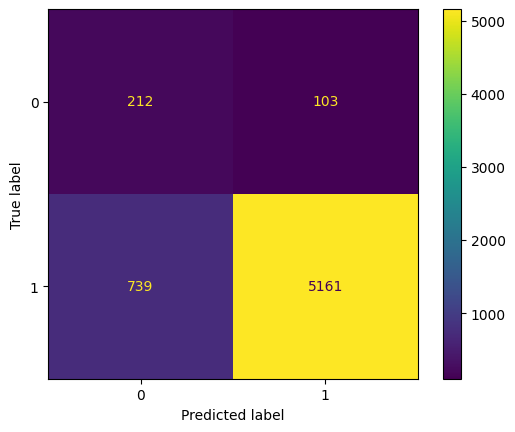

In [6]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [7]:
for col in cate_features:
    X_test[col] = X_test[col].astype('object')

In [8]:
# ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
#      X_test,
#      model=model,
#      sensitive_attribute='gender',
#      missing_subgroup_val="Unknown"
#  )

# print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
# rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

In [9]:
#  #### Uncomment if you wish to save rules object on disk

# import dill

# with open("rulesLawSchool.data", "wb") as outf:
#      dill.dump(rules_by_if, outf)

In [10]:

import dill

with open("rulesLawSchool.data", "rb") as inf:
    rules_by_if = dill.load(inf)


In [11]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["male"][1][0][1]-e[1]["female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If ugpa = 2.8, tier = 2.0:
	Subgroup 'female', 1.0893% covered
		Make ugpa = 3.2, tier = 3.0 with correctness 0.0000%.
		Make ugpa = 3.0, tier = 3.0 with correctness 0.0000%.
		Make ugpa = 3.4, tier = 3.0 with correctness 0.0000%.
		Make ugpa = 3.4, tier = 4.0 with correctness 0.0000%.
		Make ugpa = 3.6, tier = 4.0 with correctness 20.0000%.
		Make ugpa = 2.9, tier = 3.0 with correctness 0.0000%.
		Make ugpa = 3.7, tier = 4.0 with correctness 20.0000%.
		Make ugpa = 3.2, tier = 4.0 with correctness 0.0000%.
		Make ugpa = 3.4, tier = 5.0 with correctness 60.0000%.
		Make ugpa = 2.8, tier = 3.0 with correctness 0.0000%.
		Make ugpa = 3.1, tier = 4.0 with correctness 0.0000%.
		Make ugpa = 2.7, tier = 3.0 with correctness 0.0000%.
		Make ugpa = 3.0, tier = 4.0 with correctness 0.0000%.
		Make ugpa = 3.8, tier = 4.0 with correctness 20.0000%.
		Make ugpa = 2.9, tier = 4.0 with correctness 0.0000%.
		Make ugpa = 3.9, tier = 4.0 with correctness 20.0000%.
		Make ugpa = 3.8, tier = 3.0 with c

# Filter rules by different scoring functions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [12]:
feature_weights = {"gender": 1, "race1": 1}
comparators = gfacts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## For each if-group, inner product of then costs and correctness-es, divided by the number of terms

In [13]:
rules_max_costdiff_sorted = gfacts.sort_triples_by_max_costdiff(rules_by_if, params=params)

top = dict(rules_max_costdiff_sorted[:K])
print(recourse_report_reverse(
    top,
    population_sizes = {"male": (X.gender == "male").sum(), "female": (X.gender == "female").sum()},
    missing_subgroup_val="Unknown",
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(list(top.keys()), list(top.values()))
))

If fulltime = 1.0, tier = 3.0, lsat = 28.0:
	Subgroup 'female', 2.6144% covered out of 9064
		Make fulltime = 1.0, tier = 3.0, lsat = 41.0 with correctness 25.0000%.
		Make fulltime = 1.0, tier = 5.0, lsat = 41.0 with correctness 41.6667%.
		Aggregate cost of the above recourses = 0.541667
	Subgroup 'male', 2.8689% covered out of 11652
		Make fulltime = 1.0, tier = 3.0, lsat = 41.0 with correctness 71.4286%.
		Make fulltime = 1.0, tier = 5.0, lsat = 41.0 with correctness 78.5714%.
		Aggregate cost of the above recourses = 1.14286
If race1 = white, lsat = 31.0, fam_inc = 3.0:
	Subgroup 'female', 1.3072% covered out of 9064
		Make race1 = white, lsat = 36.0, fam_inc = 3.0 with correctness 16.6667%.
		Make race1 = white, lsat = 41.0, fam_inc = 3.0 with correctness 16.6667%.
		Make race1 = white, lsat = 44.0, fam_inc = 3.0 with correctness 33.3333%.
		Make race1 = white, lsat = 43.0, fam_inc = 3.0 with correctness 33.3333%.
		Aggregate cost of the above recourses = 0.25
	Subgroup 'male', 1

#### Filter rules that are approximately contained in other rules.

First, we filter only the top rules.

In [14]:
print(recourse_report_reverse(
    gfacts.filter_contained_rules(top),
    population_sizes = {"male": (X.gender == "male").sum(), "female": (X.gender == "female").sum()},
    missing_subgroup_val="Unknown",
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(list(top.keys()), list(top.values()))
))

If race1 = white, lsat = 31.0, fam_inc = 3.0:
	Subgroup 'female', 1.3072% covered out of 9064
		Make race1 = white, lsat = 36.0, fam_inc = 3.0 with correctness 16.6667%.
		Make race1 = white, lsat = 41.0, fam_inc = 3.0 with correctness 16.6667%.
		Make race1 = white, lsat = 44.0, fam_inc = 3.0 with correctness 33.3333%.
		Make race1 = white, lsat = 43.0, fam_inc = 3.0 with correctness 33.3333%.
		Aggregate cost of the above recourses = 0.25
	Subgroup 'male', 1.0246% covered out of 11652
		Make race1 = white, lsat = 36.0, fam_inc = 3.0 with correctness 60.0000%.
		Make race1 = white, lsat = 41.0, fam_inc = 3.0 with correctness 80.0000%.
		Make race1 = white, lsat = 44.0, fam_inc = 3.0 with correctness 80.0000%.
		Make race1 = white, lsat = 43.0, fam_inc = 3.0 with correctness 80.0000%.
		Aggregate cost of the above recourses = 0.75
If fulltime = 1.0, Dropout = NO, lsat = 26.0:
	Subgroup 'female', 3.2680% covered out of 9064
		Make fulltime = 1.0, Dropout = NO, lsat = 36.0 with correctne

Now, we filter all rules, and then pick the top.

In [15]:
rules_max_costdiff_sorted_filtered = gfacts.filter_contained_rules(dict(gfacts.sort_triples_by_max_costdiff(rules_by_if, params=params)))

top = dict(list(rules_max_costdiff_sorted_filtered.items())[:K])
print(recourse_report_reverse(
    top,
    population_sizes = {"male": (X.gender == "male").sum(), "female": (X.gender == "female").sum()},
    missing_subgroup_val="Unknown",
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(list(top.keys()), list(top.values()))
))

If tier = 3.0, lsat = 28.0:
	Subgroup 'female', 2.8322% covered out of 9064
		Make tier = 3.0, lsat = 36.0 with correctness 30.7692%.
		Make tier = 3.0, lsat = 41.0 with correctness 30.7692%.
		Make tier = 5.0, lsat = 41.0 with correctness 46.1538%.
		Make tier = 5.0, lsat = 42.0 with correctness 53.8462%.
		Make tier = 5.0, lsat = 44.0 with correctness 53.8462%.
		Make tier = 5.0, lsat = 39.0 with correctness 46.1538%.
		Make tier = 5.0, lsat = 38.0 with correctness 38.4615%.
		Make tier = 5.0, lsat = 36.0 with correctness 30.7692%.
		Make tier = 5.0, lsat = 37.0 with correctness 30.7692%.
		Make tier = 5.0, lsat = 43.0 with correctness 53.8462%.
		Aggregate cost of the above recourses = 0.769231
	Subgroup 'male', 2.8689% covered out of 11652
		Make tier = 3.0, lsat = 36.0 with correctness 50.0000%.
		Make tier = 3.0, lsat = 41.0 with correctness 71.4286%.
		Make tier = 5.0, lsat = 41.0 with correctness 78.5714%.
		Make tier = 5.0, lsat = 42.0 with correctness 78.5714%.
		Make tier = 

## For each if-group, minimum cost of change among thens that surpass a correctness threshold

In [16]:
rules_max_costdiff_sorted = gfacts.sort_triples_by_max_costdiff_ignore_nans(
    rules_by_if,
    params=params,
    group_calculator=gfacts.if_group_cost_min_change_correctness_threshold,
    cor_thres=0.5
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
top = dict(rules_max_costdiff_sorted[:K])
print(recourse_report_reverse(
    top,
    population_sizes = pop_sizes,
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(
        list(top.keys()),
        list(top.values()),
        group_calculator=gfacts.if_group_cost_min_change_correctness_threshold,
        cor_thres=0.5
    )
))

If tier = 3.0, fam_inc = 3.0:
	Subgroup 'female', 20.2614% covered out of 9064
		Make tier = 4.0, fam_inc = 3.0 with correctness 16.1290%.
		Make tier = 5.0, fam_inc = 3.0 with correctness 35.4839%.
		Make tier = 2.0, fam_inc = 3.0 with correctness 0.0000%.
		Make tier = 5.0, fam_inc = 5.0 with correctness 45.1613%.
		Make tier = 6.0, fam_inc = 3.0 with correctness 47.3118%.
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 16.5984% covered out of 11652
		Make tier = 4.0, fam_inc = 3.0 with correctness 19.7531%.
		Make tier = 5.0, fam_inc = 3.0 with correctness 43.2099%.
		Make tier = 2.0, fam_inc = 3.0 with correctness 0.0000%.
		Make tier = 5.0, fam_inc = 5.0 with correctness 64.1975%.
		Make tier = 6.0, fam_inc = 3.0 with correctness 64.1975%.
		Aggregate cost of the above recourses = 1.0
If Dropout = NO, tier = 3.0, fam_inc = 3.0:
	Subgroup 'female', 20.2614% covered out of 9064
		Make Dropout = NO, tier = 4.0, fam_inc = 3.0 with correctness 16.1290%.
		Make Dropout =

Now the pruned rules.

In [17]:
print(recourse_report_reverse(
    gfacts.filter_contained_rules(top),
    population_sizes = {"male": (X.gender == "male").sum(), "female": (X.gender == "female").sum()},
    missing_subgroup_val="Unknown",
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(list(top.keys()), list(top.values()),
    group_calculator=gfacts.if_group_cost_min_change_correctness_threshold,
    cor_thres=0.5)
))

If tier = 3.0, fam_inc = 3.0:
	Subgroup 'female', 20.2614% covered out of 9064
		Make tier = 4.0, fam_inc = 3.0 with correctness 16.1290%.
		Make tier = 5.0, fam_inc = 3.0 with correctness 35.4839%.
		Make tier = 2.0, fam_inc = 3.0 with correctness 0.0000%.
		Make tier = 5.0, fam_inc = 5.0 with correctness 45.1613%.
		Make tier = 6.0, fam_inc = 3.0 with correctness 47.3118%.
		Aggregate cost of the above recourses = inf
	Subgroup 'male', 16.5984% covered out of 11652
		Make tier = 4.0, fam_inc = 3.0 with correctness 19.7531%.
		Make tier = 5.0, fam_inc = 3.0 with correctness 43.2099%.
		Make tier = 2.0, fam_inc = 3.0 with correctness 0.0000%.
		Make tier = 5.0, fam_inc = 5.0 with correctness 64.1975%.
		Make tier = 6.0, fam_inc = 3.0 with correctness 64.1975%.
		Aggregate cost of the above recourses = 1.0
If fam_inc = 2.0, fulltime = 1.0, tier = 3.0:
	Subgroup 'female', 5.4466% covered out of 9064
		Make fam_inc = 4.0, fulltime = 1.0, tier = 5.0 with correctness 56.0000%.
		Make fam_in

## For each if-group, minimum cost of change among thens that surpass a correctness threshold

Before, when, for a subgroup, there were no thens that surpassed the threshold, the minimum cost of change was valued as infinity, and thus, as it is evident in the results, the algorithm finds many rules for which some groups surpass the threshold and some groups do not (because for those rules the difference between maximum and minimum cost of the subgroups evaluates to infinity).

Here, the difference is that we will ignore altogether rules for which the correctness drops below the threshold for all recourses (for some subgroup), considering them as "empty".

In [18]:
rules_max_costdiff_sorted = gfacts.sort_triples_by_max_costdiff_ignore_nans_infs(
    rules_by_if,
    params=params,
    group_calculator=gfacts.if_group_cost_min_change_correctness_threshold,
    cor_thres=0.5
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
top = dict(rules_max_costdiff_sorted[:K])
print(recourse_report_reverse(
    gfacts.filter_by_correctness(top, threshold=0.5),
    population_sizes = pop_sizes,
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(
        list(top.keys()),
        list(top.values()),
        group_calculator=gfacts.if_group_cost_min_change_correctness_threshold,
        cor_thres=0.5
    )
))

If lsat = 28.0, fam_inc = 3.0:
	Subgroup 'female', 2.3965% covered out of 9064
		Make lsat = 45.0, fam_inc = 4.0 with correctness 72.7273%.
		Aggregate cost of the above recourses = 2.0
	Subgroup 'male', 2.2541% covered out of 11652
		Make lsat = 40.0, fam_inc = 4.0 with correctness 81.8182%.
		Make lsat = 37.0, fam_inc = 3.0 with correctness 54.5455%.
		Make lsat = 40.0, fam_inc = 3.0 with correctness 81.8182%.
		Make lsat = 38.0, fam_inc = 3.0 with correctness 63.6364%.
		Make lsat = 39.0, fam_inc = 3.0 with correctness 81.8182%.
		Make lsat = 35.0, fam_inc = 3.0 with correctness 54.5455%.
		Make lsat = 36.0, fam_inc = 3.0 with correctness 54.5455%.
		Make lsat = 41.0, fam_inc = 3.0 with correctness 81.8182%.
		Make lsat = 42.0, fam_inc = 3.0 with correctness 81.8182%.
		Make lsat = 45.0, fam_inc = 4.0 with correctness 81.8182%.
		Make lsat = 44.0, fam_inc = 3.0 with correctness 81.8182%.
		Make lsat = 43.0, fam_inc = 3.0 with correctness 81.8182%.
		Aggregate cost of the above recou

Now the pruned rules.

In [19]:
print(recourse_report_reverse(
    gfacts.filter_by_correctness(gfacts.filter_contained_rules(top), threshold=0.5),
    population_sizes = {"male": (X.gender == "male").sum(), "female": (X.gender == "female").sum()},
    missing_subgroup_val="Unknown",
    subgroup_costs=gfacts.calculate_all_if_subgroup_costs(list(top.keys()), list(top.values()),
    group_calculator=gfacts.if_group_cost_min_change_correctness_threshold,
    cor_thres=0.5)
))

If lsat = 28.0, fam_inc = 3.0:
	Subgroup 'female', 2.3965% covered out of 9064
		Make lsat = 45.0, fam_inc = 4.0 with correctness 72.7273%.
		Aggregate cost of the above recourses = 2.0
	Subgroup 'male', 2.2541% covered out of 11652
		Make lsat = 40.0, fam_inc = 4.0 with correctness 81.8182%.
		Make lsat = 37.0, fam_inc = 3.0 with correctness 54.5455%.
		Make lsat = 40.0, fam_inc = 3.0 with correctness 81.8182%.
		Make lsat = 38.0, fam_inc = 3.0 with correctness 63.6364%.
		Make lsat = 39.0, fam_inc = 3.0 with correctness 81.8182%.
		Make lsat = 35.0, fam_inc = 3.0 with correctness 54.5455%.
		Make lsat = 36.0, fam_inc = 3.0 with correctness 54.5455%.
		Make lsat = 41.0, fam_inc = 3.0 with correctness 81.8182%.
		Make lsat = 42.0, fam_inc = 3.0 with correctness 81.8182%.
		Make lsat = 45.0, fam_inc = 4.0 with correctness 81.8182%.
		Make lsat = 44.0, fam_inc = 3.0 with correctness 81.8182%.
		Make lsat = 43.0, fam_inc = 3.0 with correctness 81.8182%.
		Aggregate cost of the above recou